In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
learning_rate = 0.03
num_epochs = 30
batch_size = 1
num_trainimgs = 234
num_valimgs = 26
#decay_step = int(num_trainimgs / batch_size * 10)
decay_step = 10000
decay_rate = 0.75
seed = 777
tf.set_random_seed(seed)

In [3]:
#cur_dir = os.getcwd()
#data_dir = cur_dir
data_dir = '/content/gdrive/My Drive/Tensorflow_Training_11th/'
TRAIN_FILE = 'train_images.tfrecords'
VALIDATION_FILE = 'val_images.tfrecords'

In [4]:
def print_tensor_shape(tensor, string):
    print(string, tensor.get_shape())

In [5]:
## tfrecord parsing
def read_and_decode(tfrecord_serialized):
    features={'img_raw': tf.FixedLenFeature([], tf.string),
             'label_raw': tf.FixedLenFeature([], tf.string)}
    parsed_features = tf.parse_single_example(tfrecord_serialized, features)
    
    image = tf.decode_raw(parsed_features['img_raw'], tf.int64)
    image.set_shape([65536])
    image_re = tf.reshape(image, [256, 256])
    image_re = tf.cast(image_re, tf.float32) * (1. / 1024)
    label = tf.decode_raw(parsed_features['label_raw'], tf.uint8)
    label.set_shape([65536])
    label_re = tf.reshape(label, [256, 256])
    
    return image_re, label_re

In [6]:
## Dataset 구성
def make_dataset(batch_size, tfrecord_path):    
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(read_and_decode, num_parallel_calls=8)
    dataset = dataset.shuffle(buffer_size=10000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()
    return dataset   

In [7]:
## Network 구성 - simplified U-Net
def network(images):
    print_tensor_shape(images, 'input images shape')
    image_re = tf.reshape(images, [-1, 256, 256, 1])
    print_tensor_shape(images, 'input images shape after reshaping')
    
    ## Contraction
    conv1 = tf.layers.conv2d(image_re,
                             filters=64,
                             kernel_size=[3,3],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[1,1],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv1')
    print_tensor_shape(conv1, 'conv1 shape')
    
    conv2 = tf.layers.conv2d(conv1,
                             filters=128,
                             kernel_size=[5,5],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[2,2],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv2')
    print_tensor_shape(conv2, 'conv2 shape')
    
    conv3 = tf.layers.conv2d(conv2,
                             filters=256,
                             kernel_size=[5,5],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[2,2],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv3')
    print_tensor_shape(conv3, 'conv3 shape')
    
    conv4 = tf.layers.conv2d(conv3,
                             filters=512,
                             kernel_size=[5,5],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[2,2],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv4')
    print_tensor_shape(conv4, 'conv4 shape')
    
    conv5 = tf.layers.conv2d(conv4,
                             filters=1024,
                             kernel_size=[5,5],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[2,2],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv5')
    print_tensor_shape(conv5, 'conv5 shape')
    
    ## Expansion
    upconv6 = tf.layers.conv2d_transpose(conv5,
                             filters=512,
                             kernel_size=[5,5],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[2,2],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='upconv6')
    print_tensor_shape(upconv6, 'upconv6 shape')
    
    concat6 = tf.concat([conv4, upconv6], axis=-1)
    
    conv6 = tf.layers.conv2d(concat6,
                             filters=512,
                             kernel_size=[3,3],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[1,1],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv6')
    print_tensor_shape(conv6, 'conv6 shape')
    
    upconv7 = tf.layers.conv2d_transpose(conv6,
                             filters=256,
                             kernel_size=[5,5],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[2,2],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='upconv7')
    print_tensor_shape(upconv7, 'upconv7 shape')
    
    concat7 = tf.concat([conv3, upconv7], axis=-1)
    
    conv7 = tf.layers.conv2d(concat7,
                             filters=256,
                             kernel_size=[3,3],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[1,1],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv7')
    print_tensor_shape(conv7, 'conv7 shape')
    
    upconv8 = tf.layers.conv2d_transpose(conv7,
                             filters=128,
                             kernel_size=[5,5],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[2,2],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='upconv8')
    print_tensor_shape(upconv8, 'upconv8 shape')
    
    concat8 = tf.concat([conv2, upconv8], axis=-1)
    
    conv8 = tf.layers.conv2d(concat8,
                             filters=128,
                             kernel_size=[3,3],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[1,1],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv8')
    print_tensor_shape(conv8, 'conv8 shape')
    
    upconv9 = tf.layers.conv2d_transpose(conv8,
                             filters=64,
                             kernel_size=[5,5],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[2,2],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='upconv9')
    print_tensor_shape(upconv9, 'upconv9 shape')
    
    concat9 = tf.concat([conv1, upconv9], axis=-1)
    
    conv9 = tf.layers.conv2d(concat9,
                             filters=64,
                             kernel_size=[3,3],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[1,1],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv9')
    print_tensor_shape(conv9, 'conv9 shape')
    
    conv10 = tf.layers.conv2d(conv9,
                             filters=64,
                             kernel_size=[3,3],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[1,1],
                             activation=tf.nn.relu,
                             use_bias=False,
                             padding='same',
                             name='conv10')
    print_tensor_shape(conv10, 'conv10 shape')
    
    conv11 = tf.layers.conv2d(conv10,
                             filters=2,
                             kernel_size=[1,1],
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed),
                             strides=[1,1],                             
                             use_bias=False,
                             padding='same',
                             name='conv11')
    print_tensor_shape(conv11, 'conv11 shape')
    
    return conv11

In [8]:
## loss function 정의 - cross entropy
def loss(logits, labels):
    labels = tf.to_int64(labels)
    print_tensor_shape(logits, 'logits shape before')
    print_tensor_shape(labels, 'labels shape before')
    
    logits_re = tf.reshape(logits, [-1, 2])
    labels_re = tf.reshape(labels, [-1])
    print_tensor_shape(logits_re, 'logits shape after')
    print_tensor_shape(labels_re, 'labels shale after')
    
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=logits, name='cross_entropy')
    print_tensor_shape(cross_entropy, 'cross_entropy shape')
    
    loss = tf.reduce_mean(cross_entropy, name='simple_cross_entropy_mean')
    
    return loss

In [9]:
## gradient descent with learning rate decay
def training(loss, learning_rate, decay_steps, decay_rate):
    global_step = tf.Variable(0, name='global_step', trainable=False)    
    lr = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(lr)    
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op

In [10]:
## calculate accuracy
def evaluation(logits, labels):
    with tf.name_scope('eval'):
        labels = tf.to_int64(labels)
        print_tensor_shape( logits, 'logits eval shape before')
        print_tensor_shape( labels, 'labels eval shape before')

        logits_re = tf.reshape( logits, [-1, 2] )
        labels_re = tf.reshape( labels, [-1] )
        print_tensor_shape( logits_re, 'logits eval shape after')
        print_tensor_shape( labels_re, 'labels eval shape after')

        correct = tf.nn.in_top_k(logits_re, labels_re, 1)
        print_tensor_shape( correct, 'correct shape')

        return tf.reduce_sum(tf.cast(correct, tf.int32))

In [11]:
train_tfr_path = os.path.join(data_dir, TRAIN_FILE)
val_tfr_path = os.path.join(data_dir, VALIDATION_FILE)

train_dataset = make_dataset(batch_size, train_tfr_path)
val_dataset = make_dataset(batch_size, val_tfr_path)

In [12]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
images, labels = iterator.get_next()

In [13]:
train_init = iterator.make_initializer(train_dataset)
val_init = iterator.make_initializer(val_dataset)

In [14]:
logits = network(images)

input images shape (?, 256, 256)
input images shape after reshaping (?, 256, 256)
conv1 shape (?, 256, 256, 64)
conv2 shape (?, 128, 128, 128)
conv3 shape (?, 64, 64, 256)
conv4 shape (?, 32, 32, 512)
conv5 shape (?, 16, 16, 1024)
upconv6 shape (?, 32, 32, 512)
conv6 shape (?, 32, 32, 512)
upconv7 shape (?, 64, 64, 256)
conv7 shape (?, 64, 64, 256)
upconv8 shape (?, 128, 128, 128)
conv8 shape (?, 128, 128, 128)
upconv9 shape (?, 256, 256, 64)
conv9 shape (?, 256, 256, 64)
conv10 shape (?, 256, 256, 64)
conv11 shape (?, 256, 256, 2)


In [15]:
loss = loss(logits, labels)

logits shape before (?, 256, 256, 2)
labels shape before (?, 256, 256)
logits shape after (?, 2)
labels shale after (?,)
cross_entropy shape (?, 256, 256)


In [16]:
train_op = training(loss, learning_rate, decay_step, decay_rate)

In [17]:
eval_op = evaluation(logits, labels)

logits eval shape before (?, 256, 256, 2)
labels eval shape before (?, 256, 256)
logits eval shape after (?, 256, 256, 2)
labels eval shape after (?, 256, 256)
correct shape (?,)


In [18]:
init_op = tf.global_variables_initializer()

In [19]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(init_op)

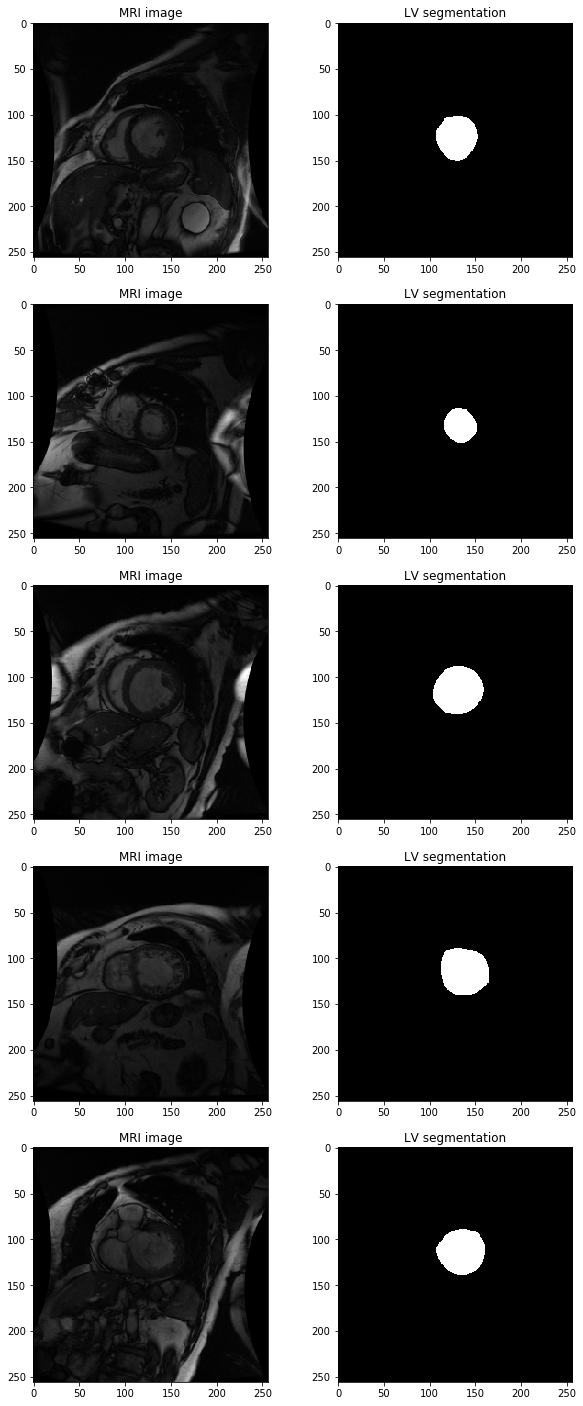

In [20]:
sess.run(train_init)
num_fig = 5
plt.figure(figsize=(10,25))
for i in range(num_fig):
    tmp_image, tmp_label = sess.run([images, labels])
    plt.subplot(num_fig, 2, 2*i+1)
    plt.title('MRI image')
    plt.imshow(tmp_image[0], cmap='gray', vmin=0, vmax=1)
    plt.subplot(num_fig, 2, 2*i+2)
    plt.title('LV segmentation')
    plt.imshow(tmp_label[0], cmap='gray', vmin=0, vmax=1)
plt.show()

Learning started. It takes sometime.
OUTPUT: epoch 1: loss = 0.21109, train_precision = 0.981, val_precision = 0.981
OUTPUT: epoch 2: loss = 0.10362, train_precision = 0.984, val_precision = 0.981
OUTPUT: epoch 3: loss = 0.08668, train_precision = 0.984, val_precision = 0.981
OUTPUT: epoch 4: loss = 0.07648, train_precision = 0.984, val_precision = 0.981
OUTPUT: epoch 5: loss = 0.06727, train_precision = 0.984, val_precision = 0.981
OUTPUT: epoch 6: loss = 0.06276, train_precision = 0.984, val_precision = 0.981
OUTPUT: epoch 7: loss = 0.05661, train_precision = 0.985, val_precision = 0.981
OUTPUT: epoch 8: loss = 0.04906, train_precision = 0.986, val_precision = 0.983
OUTPUT: epoch 9: loss = 0.04597, train_precision = 0.987, val_precision = 0.985


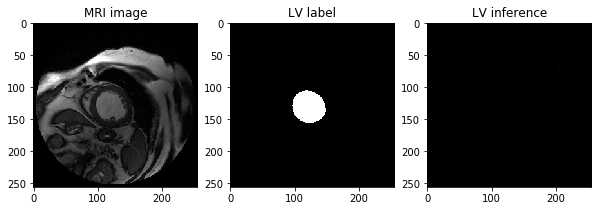

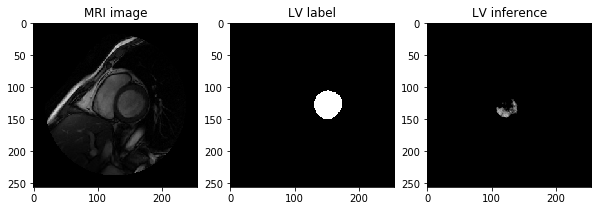

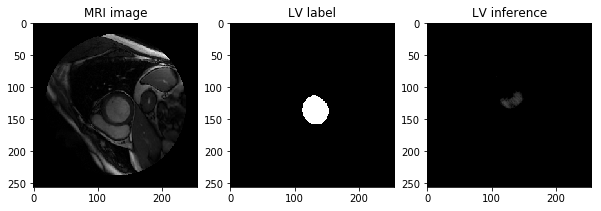

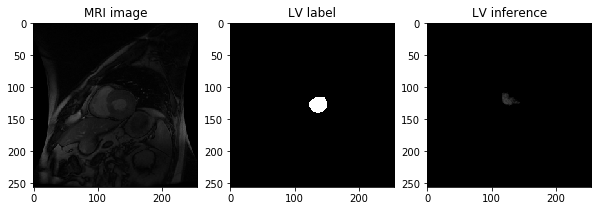

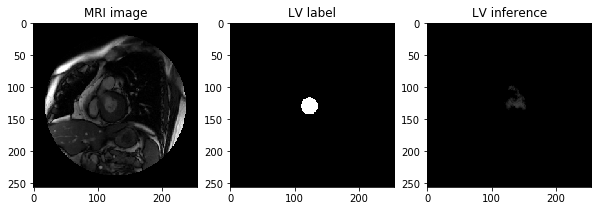

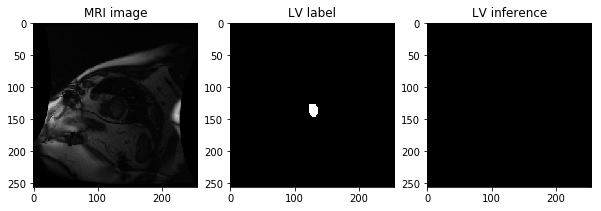

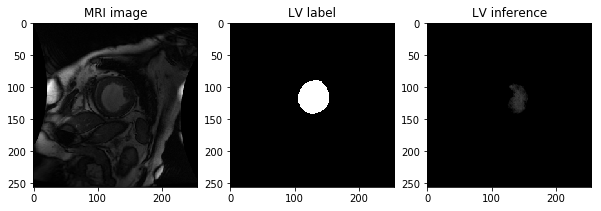

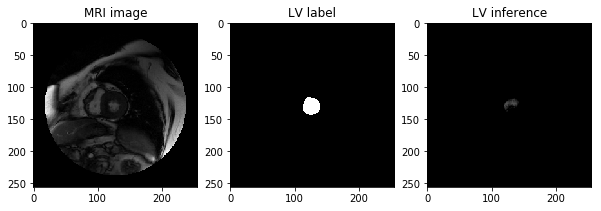

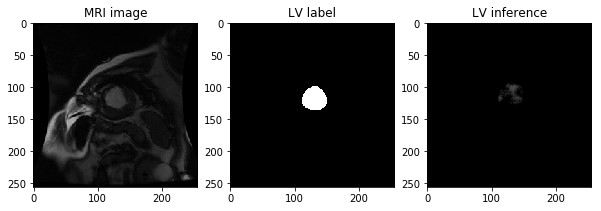

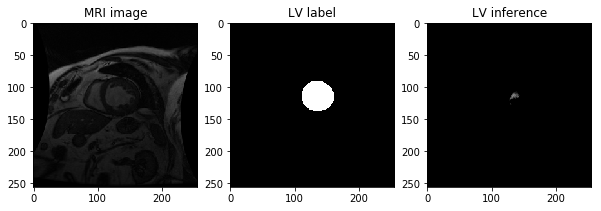

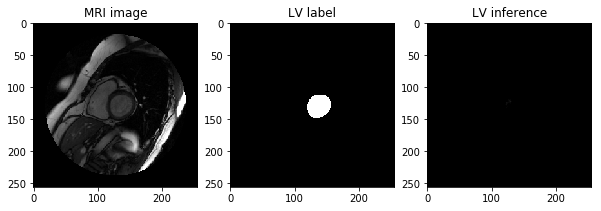

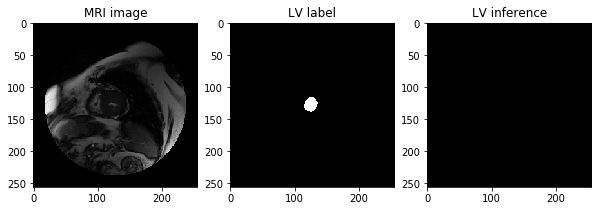

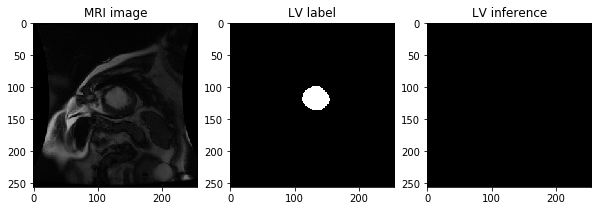

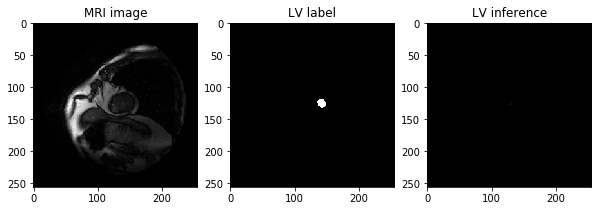

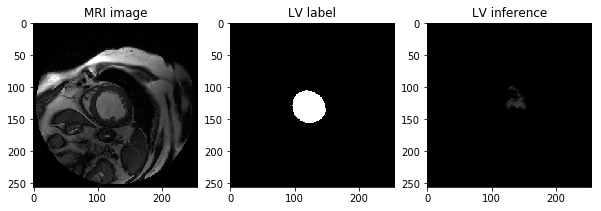

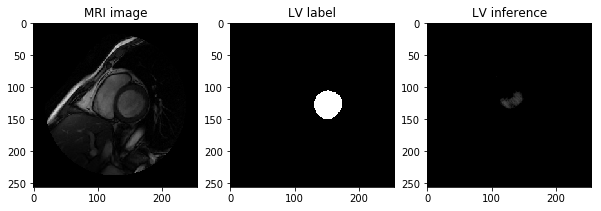

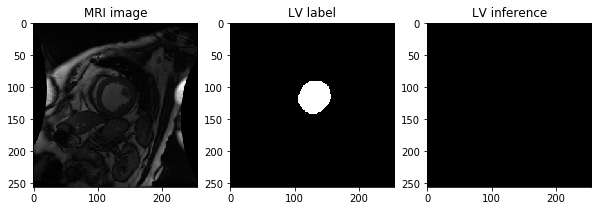

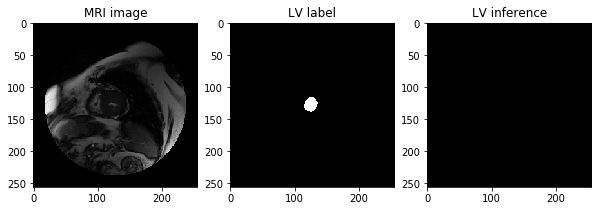

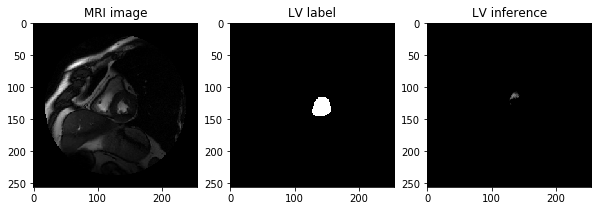

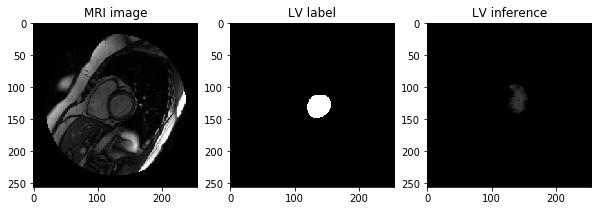

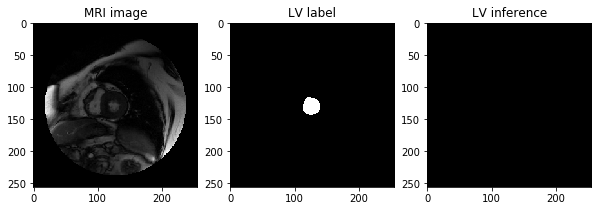

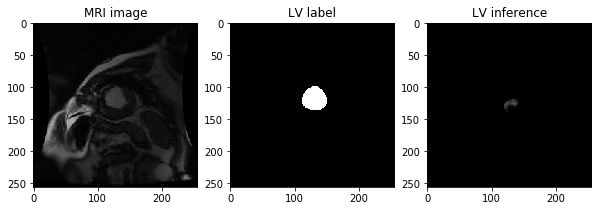

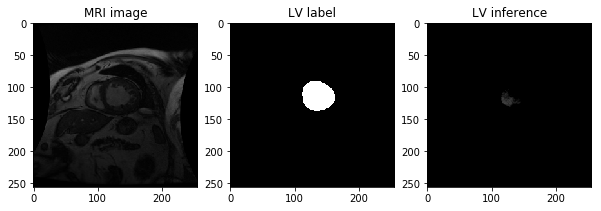

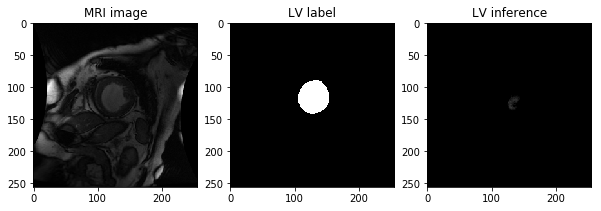

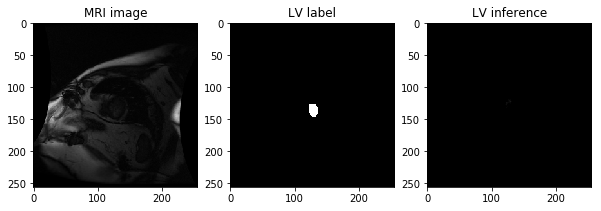

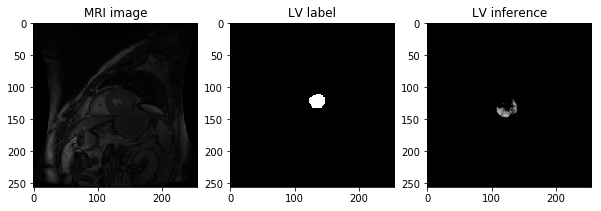

OUTPUT: epoch 10: loss = 0.04182, train_precision = 0.988, val_precision = 0.986
OUTPUT: epoch 11: loss = 0.03543, train_precision = 0.989, val_precision = 0.990
OUTPUT: epoch 12: loss = 0.03128, train_precision = 0.990, val_precision = 0.992
OUTPUT: epoch 13: loss = 0.02919, train_precision = 0.990, val_precision = 0.993
OUTPUT: epoch 14: loss = 0.02456, train_precision = 0.991, val_precision = 0.994
OUTPUT: epoch 15: loss = 0.05979, train_precision = 0.985, val_precision = 0.982
OUTPUT: epoch 16: loss = 0.03835, train_precision = 0.989, val_precision = 0.992
OUTPUT: epoch 17: loss = 0.02319, train_precision = 0.992, val_precision = 0.994
OUTPUT: epoch 18: loss = 0.01857, train_precision = 0.993, val_precision = 0.994
OUTPUT: epoch 19: loss = 0.01574, train_precision = 0.994, val_precision = 0.995


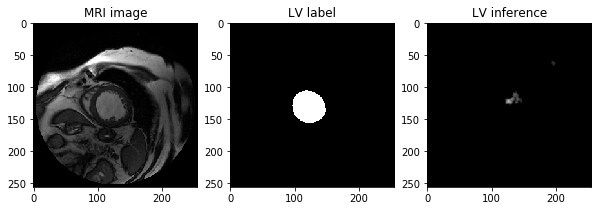

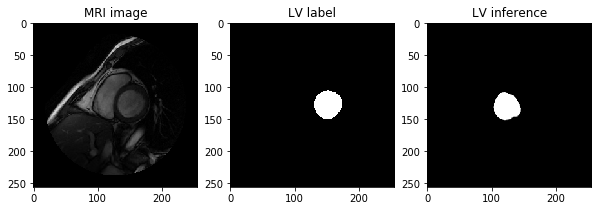

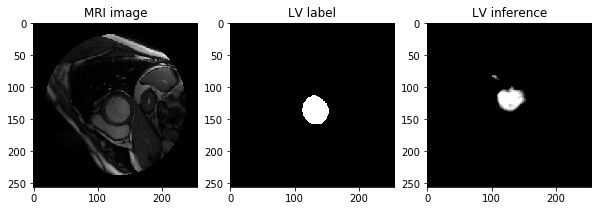

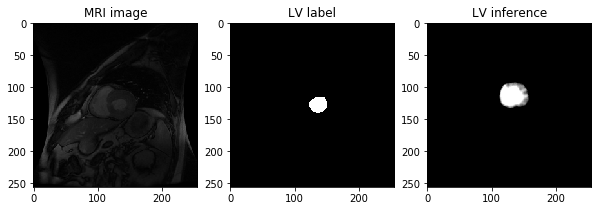

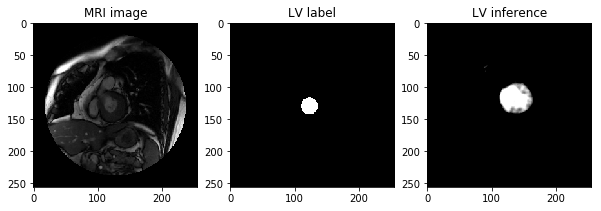

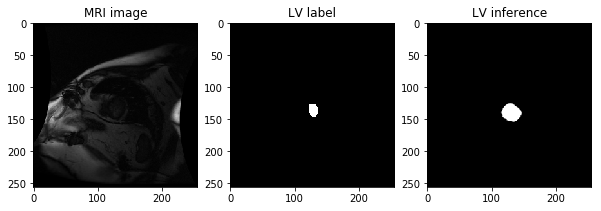

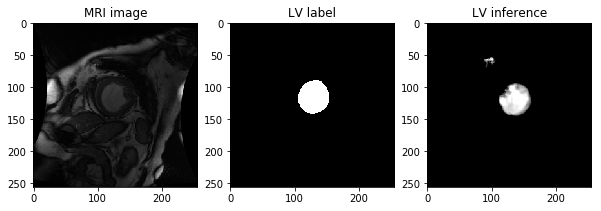

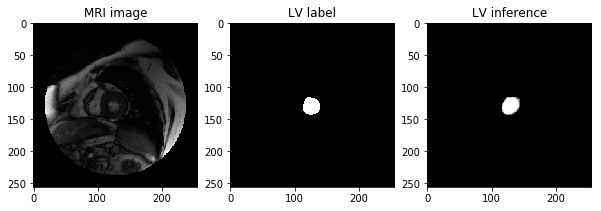

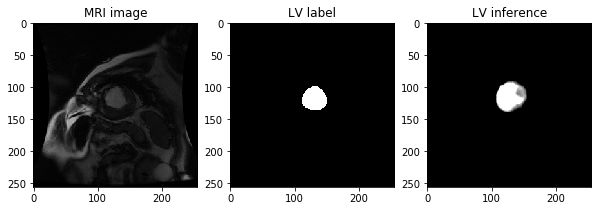

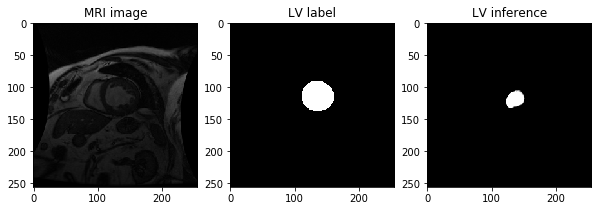

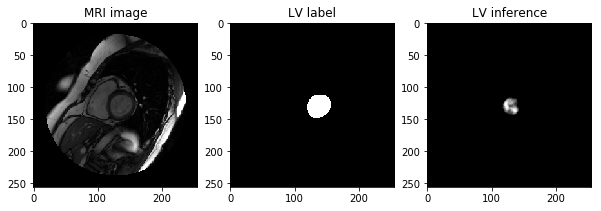

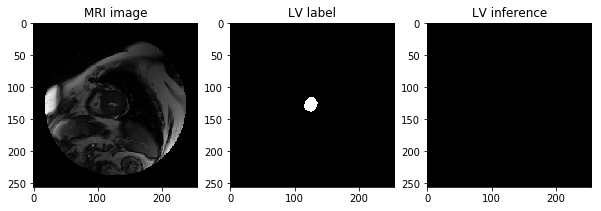

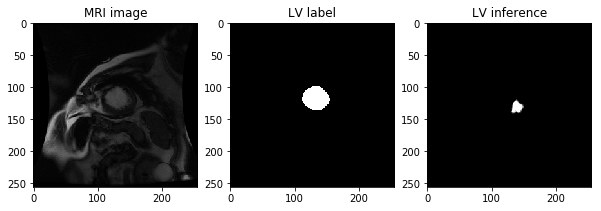

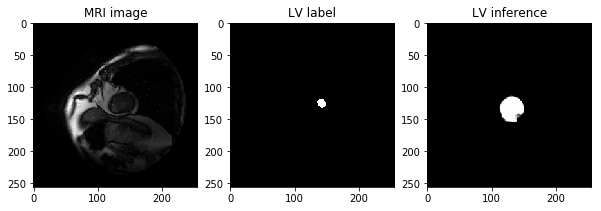

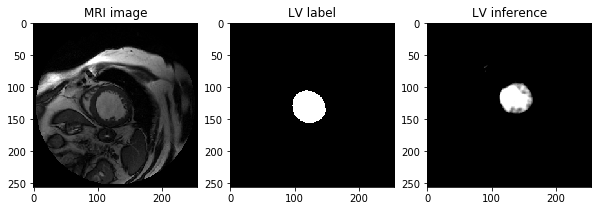

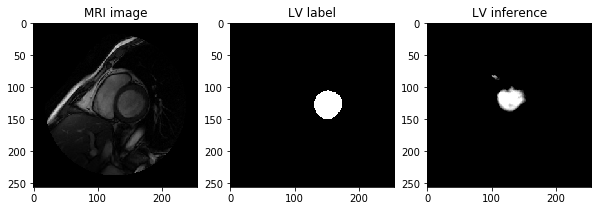

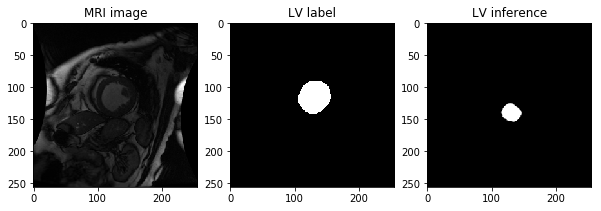

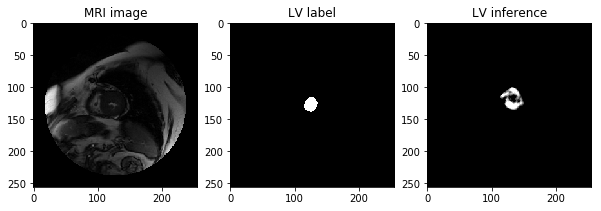

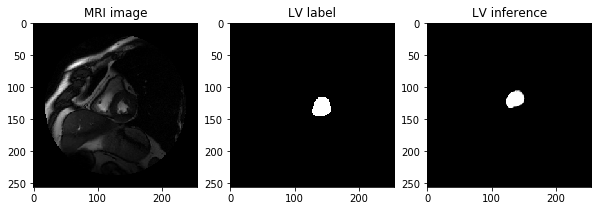

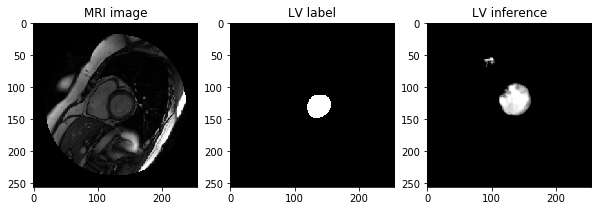

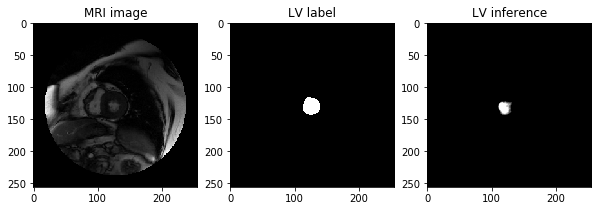

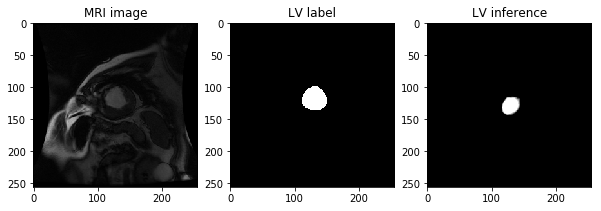

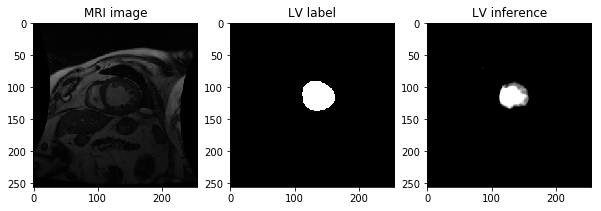

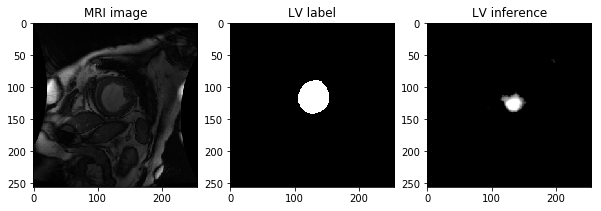

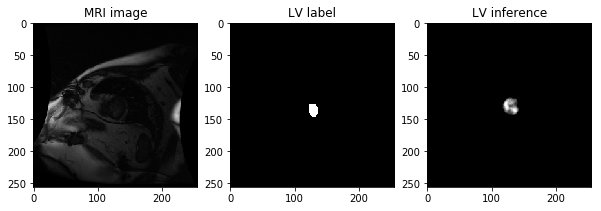

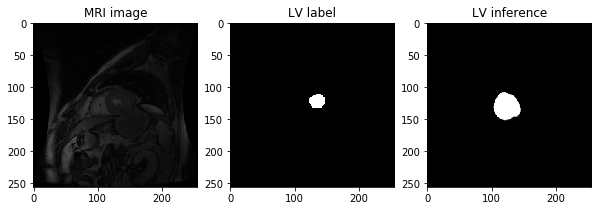

OUTPUT: epoch 20: loss = 0.01371, train_precision = 0.994, val_precision = 0.996


KeyboardInterrupt: 

In [21]:
print('Learning started. It takes sometime.')
for epoch in range(num_epochs):
    avg_loss = 0.
    avg_prec_train = 0.
    avg_prec_val = 0.
    n_iter_train = int(num_trainimgs / batch_size)
    n_iter_val = int(num_valimgs / batch_size)
    
    sess.run(train_init)    
    for i in range(n_iter_train):
        #sess.run([images, labels])
        _, loss_val = sess.run([train_op, loss])
        prec = sess.run(eval_op)
        avg_loss += loss_val / n_iter_train
        avg_prec_train += prec / (n_iter_train * 256.0 * 256)
    
    sess.run(val_init)
    for i in range(n_iter_val):
        val_images, val_labels = sess.run([images, labels])
        val_logits, prec = sess.run([logits, eval_op])
        avg_prec_val += prec / (n_iter_val * 256.0 * 256)
        if ((epoch+1) % 10 == 0):            
            val_images = np.reshape(val_images, (256, 256))
            val_labels = np.reshape(val_labels, (256, 256))
            val_logits = np.reshape(val_logits[:,:,:,1], (256, 256))
            
            plt.figure(figsize=(10,50))
            plt.subplot(131)
            plt.title('MRI image')
            plt.imshow(val_images, cmap='gray', vmin=0, vmax=1)
            plt.subplot(132)
            plt.title('LV label')
            plt.imshow(val_labels, cmap='gray', vmin=0, vmax=1)
            plt.subplot(133)
            plt.title('LV inference')
            plt.imshow(val_logits, cmap='gray', vmin=0, vmax=1)
            plt.show()    
    
    print('OUTPUT: epoch {}: loss = {:.5f}, train_precision = {:.3f}, val_precision = {:.3f}'.format(        epoch+1, avg_loss, avg_prec_train, avg_prec_val ))

print('Done Training for {} epochs'.format(num_epochs))